# Neural Network for protein contact prediction
Model setup based on Lena, et. al - Deep architectures for protein contact map prediction

# Control

In [1]:
control = {
    'pip': False,                 # add custom packages to environment
    'input': 'uselocal',          # determines where to fetch input: download_raw, download_input, uselocal
    'upload_input': False,        # upload parsed input sources to S3 for re-use
    'experiments': 's3bucket',    # where to get experiments.json: uselocal, s3bucket
    'exp_start': 'continue',      # if results.csv exists, determine whether to 'restart' or 'continue'
    'run_model': True,            # determine whether to run model, otherwise only create input visulalize results
    'results': 's3bucket',        # where to save experiments results: uselocal, s3bucket
    's3bucket': 'protein-contact' # defines s3 bucket, can be none if not used
}

# Environment setup

In [2]:
if control['pip'] == False:
    print('Skipping install of python packages')

else:
    !pip install boto3
    !pip install requests
    !pip install pandas
    !pip install sklearn
    !pip install seaborn
    !pip install matplotlib
    !pip install --upgrade --force-reinstall --ignore-installed tensorflow==1.13.1
    !pip install git+git://github.com/mikepm35/biopython.git@all_changes

Skipping install of python packages


In [3]:
import urllib
import tarfile
import gzip
import shutil
import itertools as it
import math
import re
import json

import requests
import boto3
import botocore

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO, pairwise2
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB import parse_pdb_header
from Bio.PDB import calc_dihedral
from Bio.SeqUtils.ProtParam import ProteinAnalysis

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K

In [190]:
print(tf.VERSION)

1.13.1


# Data preparation

### Download raw data

In [191]:
# Astral domain data - version 2.05 <20% identity
astral_url = 'http://scop.berkeley.edu/downloads/scopeseq-2.05/astral-scopedom-seqres-gd-sel-gs-bib-20-2.05.fa'
astral_file = astral_url.split('/')[-1]

# Astral PDB style data
pdb_url = 'http://scop.berkeley.edu/downloads/pdbstyle/pdbstyle-sel-gs-bib-40-2.05.tgz'
pdb_file = pdb_url.split('/')[-1]

# PDB secondary structure file
ss_url = 'https://cdn.rcsb.org/etl/kabschSander/ss.txt.gz'

In [192]:
if control['input'] != 'download_raw':
    print('Skipping download of raw data')

else:
    print('Starting download of Astral domain file')
    urllib.request.urlretrieve(astral_url, astral_file)
    
    print('Starting download of Astral PDB-style data (~745MB)')
    urllib.request.urlretrieve(pdb_url, pdb_file) # takes a while, 745MB
    tarfile.open(pdb_file, 'r').extractall('./')
    
    print('Starting download of PDB secondary structure file')
    urllib.request.urlretrieve(ss_url, ss_file)
    with gzip.open(ss_file,"rb") as f_in:
        with open(ss_file.replace('.gz',''),"wb") as f_out:
            shutil.copyfileobj(f_in, f_out)    

Skipping download of raw data


### Functions to parse raw data
According to the paper, the following filters are applied on the data:
- Length < 50 residues
- Filter out multiple 3D structures
- Filter out non-contiguous domains (including those with missing backbone atoms)
- Select one representative domain (shortest one) per SCOP family
- Ignore robustness coils, short strands (3 residues), and short helices (6 residues)

DSSP classifications use the following code:
```
Code	Secondary structure
H	α-helix
B	Isolated β-bridge residue
E	Strand
G	3-10 helix
I	Π-helix
T	Turn
S	Bend
-	Other
```
An 'X' in the sequence indicates a residue of unknown identity.
A blank in the ss.txt file stands for a loop or other irregular structure.

In [193]:
def _astral_pdb_parser(astral_id, root_dir='./pdbstyle-2.05/'):
    """
    For a given astral domain id, finds and parses the PDB file.
    Returns a dictionary with pdb_id and SCOP family.
    Returns None if PDB file not found or doesn't meet length or gap requirements.
    """
    
    try:
        # header = parse_pdb_header('./pdbstyle-2.05/'+astral_id[2:4]+'/'+astral_id[2:4]+'.ent')
        parser = PDBParser(PERMISSIVE=1)
        structure = parser.get_structure(
            astral_id[2:4], 
            root_dir+astral_id[2:4]+'/'+astral_id+'.ent'
        )
    
    except FileNotFoundError:
        return None
    
    valid = True
        
    # get_list() returns number of 3D models in file
    if len(structure.get_list()) > 1:
        valid = False

    # check atom gaps
    residue_start = None
    residue_cnt = 0
    for residue in structure.get_residues():
        residue_cnt += 1
        residue_end = residue.id[1]
        if not residue_start:
            residue_start = residue_end

    if (residue_end - residue_start + 1) != residue_cnt:
        valid = False  

    if not valid:
        return None
    
    else:
        return {
            'pdb_id': structure.header['astral']['Source-PDB'], 
            'family': structure.header['astral']['SCOPe-sccs']
        }
    

In [194]:
def _get_astral_domains(filename=astral_file):
    """
    Uses Biopython module to parse astral fasta files.
    Returns dataframe filters for shortest domain length per family.
    """
    
    print('Starting _get_astral_domains()...')
    
    astral_records = []
    for seq_record in SeqIO.parse(filename, "fasta"):
        pdb_data = _astral_pdb_parser(seq_record.id)

        if len(seq_record) >= 50 and pdb_data:
            astral_records.append({
                'astral_id': seq_record.id, 
                'ss_id': seq_record.id[1:-1],
                'astral_sequence': str(seq_record.seq),
                'astral_sequence_len': len(seq_record.seq),
                'pdb_id': pdb_data['pdb_id'],
                'family': pdb_data['family']
            })

    df_domains = pd.DataFrame(astral_records)
 
    # filter to shortert domain length per family
    idx_family_max = df_domains.groupby(['family'])['astral_sequence_len'].transform(max) == df_domains['astral_sequence_len']
    df_domains = df_domains[idx_family_max]
    
    # filter out domains with multiple families
    idx_family_count = df_domains.groupby(['ss_id'])['family'].transform('size') == 1
    df_domains = df_domains[idx_family_count]
    
    return df_domains
    

In [195]:
def _get_secondary_structures(filename='ss.txt'):
    """
    Parses PDB secondary structure file according to dssp classification and returns two dataframes:
        df_ss: secondary structure sequences with pdb id as key
        df_sse: individual elements for a given pdb id with pdb_id and element index as key
        
    Filter out any elements that have multiple structures
    """
    
    print('Starting _get_secondary_structures()...')

    ss_records = []
    sse_records = []
    ss_ids = set()
    ss_id_dups = set()
    for ss_record in SeqIO.parse('ss.txt', "pdb-ss"):
        title = ss_record.id.split(':')

        if title[2].lower() != 'secstr':
            continue    

        pdb_id = title[0].lower()
        ss_id = pdb_id + title[1].lower()
        ss_record_seq = str(ss_record.seq).replace('\n','').replace(' ','_')
                
        if ss_id in ss_ids:
            ss_id_dups.add(ss_id)
            continue
        else:
            ss_ids.add(ss_id)

        ss_records.append({
            'pdb_id': pdb_id,
            'ss_id': ss_id,
            'ss_sequence': ss_record_seq,
            'ss_sequence_len': len(ss_record_seq)
        })

        # get element records
        ind_end = -1
        ind_element = -1

        for dssp, group in it.groupby(ss_record_seq):
            length = len(list(group))
            ind_element = ind_element + 1
            ind_start = ind_end + 1
            ind_end = ind_start + length - 1

            ignore = False
            if (length <= 3) or (length <=6 and dssp in ('H','G','I')) or (dssp in ('-','_','X')):
                ignore = True

            # ~80% are ignored, only store non-ignored to conserve memory
            if not ignore:
                sse_records.append({
                    'sse_key': ss_id+'.'+str(ind_element),
                    'pdb_id': pdb_id,
                    'ss_id': ss_id,
                    'ind_element': ind_element,
                    'ind_start': ind_start,
                    'ind_end': ind_end,
                    'length': length,
                    'dssp': dssp,
                    'ignore': ignore
                })


    df_ss = pd.DataFrame(ss_records)
    df_sse = pd.DataFrame(sse_records)
    
    # remove duplicates
    df_ss = df_ss[~df_ss['ss_id'].isin(ss_id_dups)]
    df_sse = df_sse[~df_sse['ss_id'].isin(ss_id_dups)]
    
    return df_ss, df_sse


In [196]:
def get_domain_sse_dfs():
    """
    Retrieves domain and secondary structure dataframes.
    """
    
    df_domains = _get_astral_domains()
    df_ss, df_sse = _get_secondary_structures()
    
    # Merge domain records with secondary structure and exclude where lengths do no match
    print('Starting merge of domain records with secondary structure...')
    df_domains = df_domains.merge(df_ss, on='ss_id', how='inner', suffixes=('','_ss'))
    df_domains = df_domains[df_domains['astral_sequence_len']==df_domains['ss_sequence_len']]
    
    # Filter sse dataframe to only those domains remaining
    valid_ss_ids = set(df_domains['ss_id'].tolist())
    df_sse = df_sse[df_sse['ss_id'].isin(valid_ss_ids)]
    
    return df_domains, df_sse


### Functions to create paired data

In [197]:
def get_sse_pairs(df_sse):
    """
    Creates dataframe of valid sse pairs by pdb id
    """
    
    sse_pairs = []
    
    # Find pdb ids that have more than one non-ignored secondary structure elements
    ss_ids = list(set(df_sse[df_sse['ignore']==False].groupby('ss_id').filter(lambda x: x['ss_id'].count() > 1)['ss_id'].tolist()))
    
    # For each pdb id create unique pairs
    for ss_id in ss_ids:
        sse_keys = df_sse[(df_sse['ss_id']==ss_id)&(df_sse['ignore']==False)]['sse_key'].tolist()
        
        for idx_outer, sse_key_1 in enumerate(sse_keys):
            for idx_inner, sse_key_2 in enumerate(sse_keys):
                if idx_inner > idx_outer:
                    sse_pairs.append({
                        'ss_id': ss_id,
                        'sse_key_1': sse_key_1,
                        'sse_key_2': sse_key_2,
                        'sse_pair_key': sse_key_1+'&'+sse_key_2
                    })
    
    df_sse_pairs = pd.DataFrame(sse_pairs)
    
    return df_sse_pairs
            

In [198]:
def get_sse_neighbors(df_sse, df_sse_pairs, max_radius=7):
    """
    Create map of neighboring sse_pairs in receptive radius attribute
    """
        
    # Map sse data onto pairs
    df_sse_pairs_m = df_sse_pairs.merge(df_sse, left_on='sse_key_1', right_on='sse_key', suffixes=('', '_1'))
    df_sse_pairs_m = df_sse_pairs_m.merge(df_sse, left_on='sse_key_2', right_on='sse_key', suffixes=('', '_2'))
    
    # Self join sse data and exclude exact same pairs
    df_sse_n = df_sse_pairs_m.merge(df_sse_pairs_m, on='ss_id', how='left', suffixes=('', '_n'))
    df_sse_n = df_sse_n[df_sse_n['sse_pair_key']!=df_sse_n['sse_pair_key_n']]
    
    # Determine receptive radiuses
    df_sse_n['radius_1_1'] = (df_sse_n['ind_element']-df_sse_n['ind_element_n']).abs()
    df_sse_n['radius_1_2'] = (df_sse_n['ind_element']-df_sse_n['ind_element_2_n']).abs()
    df_sse_n['radius_2_1'] = (df_sse_n['ind_element_2']-df_sse_n['ind_element_n']).abs()
    df_sse_n['radius_2_2'] = (df_sse_n['ind_element_2']-df_sse_n['ind_element_2_n']).abs()
    
    df_sse_n['max_radius'] = df_sse_n[['radius_1_1','radius_1_2','radius_2_1','radius_2_2']].max(axis=1)
    
    # Filter by max radius
    df_sse_n = df_sse_n[df_sse_n['max_radius']<=max_radius]
    
    # Return subset of columns
    df_sse_n = df_sse_n[['ss_id', 'sse_pair_key', 'sse_pair_key_n', 'max_radius']]
    
    return df_sse_n    
    

### Functions to create feature and label vectors

In [199]:
def _get_sse_feature_vector(row, row_m1, row_p1, sse_keys):
    """
    Creates a feature vector of 109 elements for a given secondary structure element (sse)
    
    featurevector = [
        ['20: aa distribution for s-1'],
        ['20: aa distribution for s'],
        ['20: aa distribution for s+1'],
        ['3: residue len s-1, s, s+1'],
        ['2: residue len between s-1/s and s/s+1; zero for adjacent elements']
        ['4: binary flags for first, second, second-to-last, last element in sequence'],
        ['20: aa distribution for odd residues in s'],
        ['20: aa distribution for even residues in s']
    ]

    """
    
    # Amino acid order key
    aa_order = ('A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y')

    # Get element sequence flag (assumes only looking at non-ignored sequences)
    if row['sse_key'] == sse_keys[0]:
        position_flag = [1,0,0,0]
    elif row['sse_key'] == sse_keys[-1]:
        position_flag = [0,0,0,1]
    elif row['sse_key'] == sse_keys[1]:
        position_flag = [0,1,0,0]
    elif row['sse_key'] == sse_keys[-2]:
        position_flag = [0,0,1,0]
    else:
        position_flag = [0,0,0,0]
    
    # Amino acid distributions for Sn
    aa_s = row['astral_sequence'][row['ind_start']:row['ind_end']]
    aa_odd_s = aa_s[1::2]
    aa_even_s = aa_s[::2]
    
    aadistrodict_s = ProteinAnalysis(aa_s).get_amino_acids_percent()
    aadistro_s = []
    for aa in aa_order:
        aadistro_s.append(aadistrodict_s[aa])
 
    aadistrodict_s = ProteinAnalysis(aa_odd_s).get_amino_acids_percent()
    aadistro_odd_s = []
    for aa in aa_order:
        aadistro_odd_s.append(aadistrodict_s[aa])
        
    aadistrodict_s = ProteinAnalysis(aa_even_s).get_amino_acids_percent()
    aadistro_even_s = []
    for aa in aa_order:
        aadistro_even_s.append(aadistrodict_s[aa])
        
    # Amino acid distributions for Sn-1, use blank space to get empty distro
    if position_flag[0] == 1 or row_m1 is None:
        aa_s_m1 = " "
    else:
        aa_s_m1 = row_m1['astral_sequence'][row_m1['ind_start']:row_m1['ind_end']]
  
    aadistrodict_s_m1 = ProteinAnalysis(aa_s_m1).get_amino_acids_percent()
    aadistro_s_m1 = []
    for aa in aa_order:
        aadistro_s_m1.append(aadistrodict_s_m1[aa])

    # Amino acid distributions for Sn+1, use blank space to get empty distro
    if position_flag[3] == 1 or row_p1 is None:
        aa_s_p1 = " "
    else:
        aa_s_p1 = row_p1['astral_sequence'][row_p1['ind_start']:row_p1['ind_end']]
  
    aadistrodict_s_p1 = ProteinAnalysis(aa_s_p1).get_amino_acids_percent()
    aadistro_s_p1 = []
    for aa in aa_order:
        aadistro_s_p1.append(aadistrodict_s_p1[aa])
        
    # Residue lengths
    lens = [
        len(aa_s_m1) if aa_s_m1 != " " else 0, 
        len(aa_s), 
        len(aa_s_p1) if aa_s_p1 != " " else 0
    ]
    
    # Residue gaps
    if position_flag[0] == 1 or row_m1 is None or (row['ind_element']-row_m1['ind_element']) == 0:
        gap_s_m1 = 0
    else:
        gap_s_m1 = row['ind_start'] - row_m1['ind_end'] + 1
        
    if position_flag[3] == 1 or row_p1 is None or (row_p1['ind_element']-row['ind_element']) == 0:
        gap_s_p1 = 0
    else:
        gap_s_p1 = row_p1['ind_start'] - row['ind_end'] + 1  

    gaps = [gap_s_m1, gap_s_p1]
    
    # Return combined feature vector
    return aadistro_s_m1 + aadistro_s + aadistro_s_p1 + lens + gaps + position_flag + aadistro_odd_s + aadistro_even_s


In [200]:
def _get_sse_pair_label_vector(row, root_dir='./pdbstyle-2.05/'):
    """
    Retrieve the label vector which determines the contact type.
    Requires reading the PDB files to calculate geometry.
    
    label_vector = ['3: probability of parallel contact, anti-parallel contact or no-contact']
    
    """

    # Get PDB structure for each element  
    parser = PDBParser(PERMISSIVE=1)
    structure = parser.get_structure(
        row['astral_id'][2:4], 
        root_dir+row['astral_id'][2:4]+'/'+row['astral_id']+'.ent'
    )
    
    # Get residues and assign to ss elements, fill in gaps for missing residues
    residues1 = []
    residues2 = []
    ind = 0
    res_ind_start = -1000
    for residue in structure.get_residues():
        if res_ind_start == -1000:
            res_ind_start = residue.id[1]
        elif residue.id[1] != ind + res_ind_start:
            gap = residue.id[1] - ind - res_ind_start
            #print('Missing residues, adv ind by %s (%s, %s, %s, %s)' % (gap, rec['fasta'].name, residue.id[1], ind, res_ind_start))
            ind += gap
        
        if row['ind_start'] <= ind <= row['ind_end']:
            residues1.append(residue)
        elif row['ind_start_b'] <= ind <= row['ind_end_b']:
            residues2.append(residue)            
        
        ind += 1
        
    if len(residues1)<=1 or len(residues2)<=1:
        return None
             
    # Calculate angle between two ss elements
    angle = abs(calc_dihedral(
        residues1[1]['CA'].get_vector(), 
        residues1[-1]['CA'].get_vector(), 
        residues2[1]['CA'].get_vector(), 
        residues2[-1]['CA'].get_vector()
    ) * 180/math.pi) 

    # Iterate over residuce pairings and calculate distance
    distances = []
    for residue1 in residues1:
        for residue2 in residues2:
            distances.append(abs(residue1['CA'] - residue2['CA']))
            
    min_distance = min(distances)
            
    # Determine contact type
    if min_distance >= 8:
        label_vector = [0,0,1]
    elif angle < 90:
        label_vector = [0,1,0]
    elif angle >= 90:
        label_vector = [1,0,0]
    else:
        raise Exception('Unknown contact type')

    return label_vector


In [201]:
def get_sse_features(df_domains, df_sse):
    """
    Retrieve feature vectors for each sse. Utilizes data from neighboring sse's as well.
    """
    
    print('Starting get_sse_features()...')
    
    sse_features = []
    
    # group sse indicies by ss_id
    df_sse_grouped = df_sse[['ss_id','sse_key']].groupby('ss_id', as_index=False).aggregate(lambda x: tuple(x))
    df_sse_m = df_sse.merge(df_sse_grouped, on='ss_id', suffixes=('','_m'))
    
    # merge with domain data
    df_sse_m = df_sse_m.merge(df_domains, on='ss_id', suffixes=('','_d'))
    
    # find neighboring elements and pass to feature vector calculation
    for index, row in df_sse_m.iterrows():
        sse_keys = row['sse_key_m']
        
        sse_key_idx = sse_keys.index(row['sse_key'])
        
        row_m1 = None
        if sse_key_idx > 0:
            row_m1 = df_sse_m[df_sse_m['sse_key']==sse_keys[sse_key_idx-1]].iloc[0]
            
        row_p1 = None
        if sse_key_idx < len(sse_keys)-1:
            row_p1 = df_sse_m[df_sse_m['sse_key']==sse_keys[sse_key_idx+1]].iloc[0]
            
        feature_vector = _get_sse_feature_vector(row, row_m1, row_p1, sse_keys)
        
        feature_vector = [row['sse_key']] + feature_vector
        
        sse_features.append(feature_vector)
        
    
    df_sse_features = pd.DataFrame(sse_features)
    df_sse_features = df_sse_features.rename(index=str, columns={0: 'sse_key'})
    
    return df_sse_features


In [202]:
def get_sse_pair_labels(df_domains, df_sse, df_sse_pairs):
    """
    Retrieve contact type based on residue geometry for each pair.
    """
    
    print('Starting get_sse_pair_labels()...')
    
    sse_pair_labels = []
    
    # Join SSE and domain data into pairs
    df_sse_pairs_m = df_sse_pairs.merge(df_domains, on='ss_id', suffixes=('', '_d'))
    df_sse_pairs_m = df_sse_pairs_m.merge(df_sse, left_on='sse_key_1', right_on='sse_key', suffixes=('','_a'))
    df_sse_pairs_m = df_sse_pairs_m.merge(df_sse, left_on='sse_key_2', right_on='sse_key', suffixes=('','_b'))
    
    # Retrieve label vector
    for index, row in df_sse_pairs_m.iterrows():
        label_vector = _get_sse_pair_label_vector(row)
        
        if label_vector is None:
            continue
        
        label_vector = [row['sse_pair_key'], row['sse_key_1'], row['sse_key_2']] + label_vector
        
        sse_pair_labels.append(label_vector)
        
    
    df_pair_labels = pd.DataFrame(sse_pair_labels)
    df_pair_labels = df_pair_labels.rename(index=str, columns={0: 'sse_pair_key', 1: 'sse_key_1', 2: 'sse_key_2'})
    
    return df_pair_labels


### Data handling

In [203]:
s3client = boto3.client('s3')
csvs = ['sse_features.csv', 'pair_labels.csv', 'sse_pairs.csv', 'sse_neighbors.csv']


if control['input'] == 'download_raw':
    print('Parsing raw data to generate inputs...')
    
    # get parsed raw data with filters applied
    df_domains, df_sse = get_domain_sse_dfs()
    df_sse_pairs = get_sse_pairs(df_sse)
    df_sse_neighbors = get_sse_neighbors(df_sse, df_sse_pairs)
    
    # get feature data by secondary structure element (sse)
    df_sse_features = get_sse_features(df_domains, df_sse)

    # get output/label data by pair
    df_pair_labels = get_sse_pair_labels(df_domains, df_sse, df_sse_pairs)

elif control['input'] == 'download_input':
    print('Downloading input data from S3...')
    
    # download from s3
    for csv in csvs:
        s3client.download_file(control['s3bucket'], csv, './'+csv)

        
if control['input'] in ('uselocal', 'download_input'):
    print('Reading local input csv files...')
    # read csv files
    df_sse_features = pd.read_csv('./sse_features.csv')
    df_pair_labels = pd.read_csv('./pair_labels.csv')
    df_sse_pairs = pd.read_csv('./sse_pairs.csv')
    df_sse_neighbors = pd.read_csv('./sse_neighbors.csv')    


if control['upload_input'] == True:
    print('Uploading input data to S3...')

    # create csv files
    df_sse_features.to_csv('./sse_features.csv', header=True, index=False)
    df_pair_labels.to_csv('./pair_labels.csv', header=True, index=False)
    df_sse_pairs.to_csv('./sse_pairs.csv', header=True, index=False)
    df_sse_neighbors.to_csv('./sse_neighbors.csv', header=True, index=False)

    # upload to s3
    for csv in csvs:
        s3client.upload_file('./'+csv, control['s3bucket'], csv)    


Reading local input csv files...


### Prepare data for model

In [204]:
# Normalize residue length in feature data
df_sse_features_normd = df_sse_features.copy()

for c in ['61','62','63','64','65']:
    c_max = df_sse_features_normd[[c]].max()
    c_min = df_sse_features_normd[[c]].min()
    
    df_sse_features_normd[c] = df_sse_features_normd[c].apply(lambda x: (x-c_min)/(c_max-c_min))


In [205]:
# Construct 2D features dataframe
df_features_2d = df_sse_pairs.merge(df_sse_features_normd, how='inner', left_on='sse_key_1', right_on='sse_key', suffixes=('','_a'))
df_features_2d = df_features_2d.merge(df_sse_features_normd, left_on='sse_key_2', right_on='sse_key', suffixes=('','_b'))

In [206]:
# Construct labels dataframe
df_labels = df_sse_pairs.merge(df_pair_labels, how='inner', on='sse_pair_key', suffixes=('','_a'))

In [207]:
# Create empty numpy arrays
max_pairs = (7*2+1)**2 # receptive radius of 7
np_features = np.zeros((df_sse_pairs.shape[0],max_pairs,109*2), dtype=np.float32)
np_labels = np.zeros((df_sse_pairs.shape[0],3), dtype=np.float32)

In [208]:
# Add 2D data to arrays
features_2d_cols = [str(i) for i in range(1,110)] + [str(i)+'_b' for i in range(1,110)]
np_features[:,0,:] = df_features_2d[features_2d_cols].values

labels_cols = ['3','4','5']
np_labels[:,:] = df_labels[labels_cols].values


In [209]:
# Add neighbor data into second dimension of features
df_features_n = df_features_2d.merge(df_sse_neighbors, on='sse_pair_key', suffixes=('','_n1'))
df_features_n = df_features_n.merge(df_features_2d, left_on='sse_pair_key_n', right_on='sse_pair_key', suffixes=('','_n2'))

features_n_cols = [str(i)+'_n2' for i in range(1,110)] + [str(i)+'_b_n2' for i in range(1,110)]
                                                      
for index, row in df_features_2d.reset_index().iterrows(): # index matches np array
    df_n = df_features_n[(df_features_n['sse_pair_key']==row['sse_pair_key']) & (df_features_n['max_radius']<=7)].sort_values(by='max_radius', ascending=True)
    
    if df_n.shape[0] > 0:
        np_features[index,1:df_n.shape[0]+1,:] = df_n[features_n_cols].values


### Input data visualization

In [210]:
print('Number of pairs for fitting: %s' % np_features.shape[0])

Number of pairs for fitting: 33168


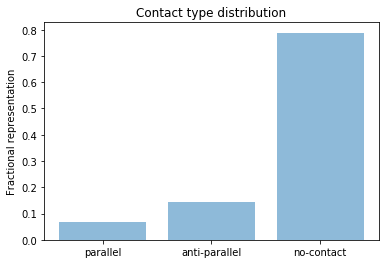

In [211]:
unique, counts = np.unique(np.array([np.where(label==1)[0][0] for label in np_labels]), return_counts=True)
class_counts = dict(zip(unique, counts))

label_dist = {
    'parallel': round(class_counts[0]/np_labels.shape[0],4), 
    'anti-parallel': round(class_counts[1]/np_labels.shape[0],4),
    'no-contact': round(class_counts[2]/np_labels.shape[0],4)
}

plt.bar(np.arange(3), [label_dist[k] for k in label_dist], align='center', alpha=0.5)
plt.xticks(np.arange(3), label_dist.keys())
plt.ylabel('Fractional representation')
plt.title('Contact type distribution')
plt.show()

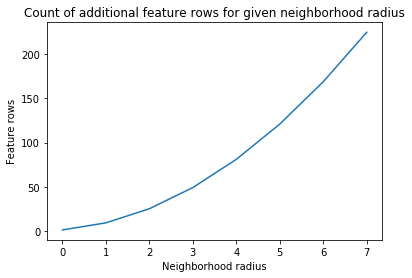

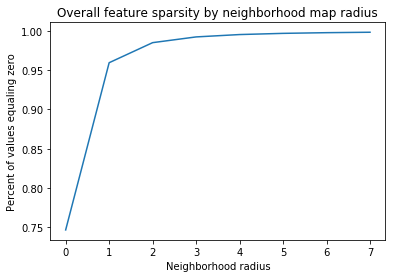

In [212]:
radii = list(range(0,8))
map_inds = [(i*2+1)**2 for i in radii]

plt.plot(radii, map_inds)
plt.title("Count of additional feature rows for given neighborhood radius")
plt.ylabel('Feature rows')
plt.xlabel('Neighborhood radius')
plt.show()

map_sparsity = []
for map_ind in map_inds:
    map_sparsity.append((np_features[:,0:map_ind,:]==0.0).sum() / (np_features.shape[0]*np_features.shape[2]*map_ind))

plt.plot(radii, map_sparsity)
plt.title("Overall feature sparsity by neighborhood map radius")
plt.ylabel('Percent of values equaling zero')
plt.xlabel('Neighborhood radius')
plt.show()

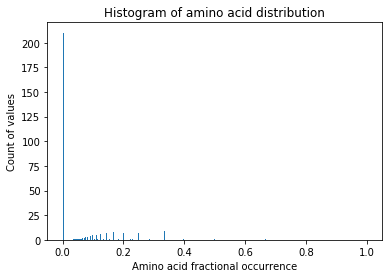

In [213]:
plt.hist(df_sse_features[[str(i) for i in range(21,41)]].values.flatten(), bins='auto', density=True)
plt.title("Histogram of amino acid distribution")
plt.ylabel('Count of values')
plt.xlabel('Amino acid fractional occurrence')
plt.show()

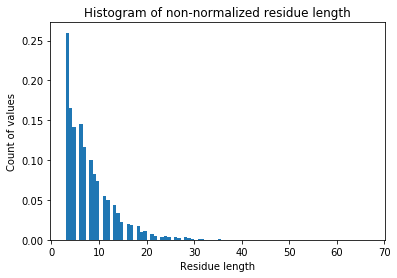

In [214]:
plt.hist(df_sse_features[['62']].values.flatten(), bins='auto', density=True)
plt.title("Histogram of non-normalized residue length")
plt.ylabel('Count of values')
plt.xlabel('Residue length')
plt.show()

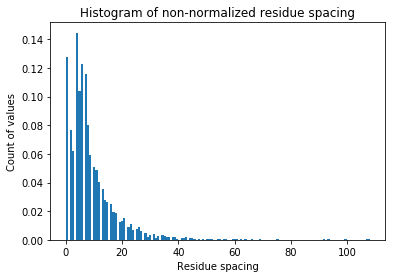

In [215]:
plt.hist(df_sse_features[['64','65']].values.flatten(), bins='auto', density=True)
plt.title("Histogram of non-normalized residue spacing")
plt.ylabel('Count of values')
plt.xlabel('Residue spacing')
plt.show()

# Model training

### Model setup

In [216]:
class MetricsCallback(tf.keras.callbacks.Callback):
    """
    Generates protein-contact specific metrics by epoch on both training and validation datasets
    using sklearn classification report.    
    """
    
    def __init__(self, train_data, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.train_data = train_data
        self.epochs = 0
        self.metrics = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.epochs += 1

        x_train = self.train_data[0]
        y_train_true = self.train_data[1]
        y_train_pred = self.model.predict(x_train)
        
        x_test = self.validation_data[0]
        y_test_true = self.validation_data[1]
        y_test_pred = self.model.predict(x_test)
                
        epoch_results = []
        
        classes = {
            '0': 'parallel', '1': 'anti-parallel', '2': 'no-contact', 
            'macro avg': 'all_macro', 'weighted avg': 'all_weighted'
        }
        
        report = {
            'train': classification_report(np.argmax(y_train_true, axis=-1), np.argmax(y_train_pred, axis=-1), output_dict=True),
            'test': classification_report(np.argmax(y_test_true, axis=-1), np.argmax(y_test_pred, axis=-1), output_dict=True)
        }
        
        for i in classes.keys():
            for d in ('train', 'test'):
                if 'all_' in classes[i]:
                    accuracy = report[d]['accuracy']
                else:
                    accuracy = 0
            
                epoch_results.append({
                    'epoch': self.epochs,
                    'dataset': d,
                    'class': classes[i],
                    'accuracy': accuracy,
                    'precision': report[d][i]['precision'],
                    'recall': report[d][i]['recall'],
                    'f1_score': report[d][i]['f1-score'],
                    'support': report[d][i]['support']
                })          
        
        self.metrics += epoch_results
                    
        return epoch_results
    

In [217]:
def get_model(layers_def, input_shape, learning_rate):
    """
    layers is a list of dictonaries describing how to build the sequential model:
    {
        'layer_type': <e.g. 'LSTM'>,
        'units': <e.g. 8>,
        'activation': <optional, e.g 'tanh'>,
        'return_sequences': <optional, e.g. True>,
        'input_shape': <optional, e.g. (2, 219)
    }
    
    Retruns compiled model
    """
    
    model = tf.keras.Sequential()
    
    rnn_shape = input_shape
    
    for layer in layers_def:
        if layer['layer_type'] == 'LSTM':
            model.add(
                layers.LSTM(
                    layer['units'], 
                    return_sequences=layer['return_sequences'], 
                    activation=layer['activation'], 
                    input_shape=rnn_shape
                )
            )
            
            rnn_shape = (layer['units'], rnn_shape[1])
        
        elif layer['layer_type'] == 'GRU':
            model.add(
                layers.GRU(
                    layer['units'], 
                    return_sequences=layer['return_sequences'], 
                    activation=layer['activation'], 
                    input_shape=rnn_shape
                )
            )
            
            rnn_shape = (layer['units'], rnn_shape[1])
        
        elif layer['layer_type'] == 'Dense':
            model.add(
                layers.Dense(
                    layer['units'], 
                    activation=layer['activation']
                )
            )
            
        elif layer['layer_type'] == 'Dropout':
            model.add(
                layers.Dropout(
                    layer['units']
                )
            )            

    model.compile(optimizer=tf.train.AdamOptimizer(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=[
                      'accuracy', # true positives / total, equals Q3
                      tf.keras.metrics.Precision(), # TP/(TP+FP) = PPV (positive predictive value)
                      tf.keras.metrics.Recall(), # TP/(TP+FN) = TPR (true positive rate)
                  ]
    )
        
    return model


In [218]:
def shuffle_and_split_inds(np_features, np_labels, split=0.9, seed=32):
    """
    Takes a feature and label arrays and creates shuffled data split into train and validation datasets.
    """
    
    np.random.seed(seed) # predicatable random distribution
    inds = list(range(np_features.shape[0]))
    np.random.shuffle(inds)
    
    train_len = int(len(inds)*split)

    np_features_train = np_features[inds[:train_len]][:][:]
    np_labels_train = np_labels[inds[:train_len]][:][:]

    np_features_val = np_features[inds[train_len:]][:][:]
    np_labels_val = np_labels[inds[train_len:]][:][:]    
    
    return np_features_train, np_labels_train, np_features_val, np_labels_val


In [219]:
def generalize_history(history):
    """
    Removes extraneous identifiers on keras history data
    """
    
    history_gen = dict()
    
    for key in history:
        key_gen = re.sub(r'_[0-9]+', '', key)
        history_gen[key_gen] = history[key]    
    
    return history_gen


In [12]:
def get_experiments_file(location, s3bucket=None):
    """
    Converts experiments.json to dictionary per location (uselocal, s3bucket)
    """
    
    if location == 's3bucket':
        print('Downloading experiments.json from s3bucket %s' % s3bucket)
        boto3.client('s3').download_file(s3bucket, 'experiments.json', './experiments.json')
        
    # read json file
    with open('experiments.json') as json_file:  
        experiments = json.load(json_file)
    
    return experiments


In [13]:
def load_results(location, s3bucket=None):
    """
    Load results file as defined by location ('uselocal', 's3bucket').
    Returns dataframe or none if file does not exist.
    """
    
    if location == 's3bucket':
        print('Downloading results.csv from s3bucket %s' % s3bucket)
        try:
            boto3.client('s3').download_file(s3bucket, 'results.csv', './results.csv')
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] != '404':
                raise
            else:
                print('results.csv not found on s3bucket')
                return None
        
    # read csv file
    try:
        df_results = pd.read_csv('./results.csv')
    except FileNotFoundError:
        df_results = None
    
    return df_results


In [14]:
def get_summary_results(df, experiment):
    """
    Converts model history and MetricsCallback to a single row result.
    """
    
    last_epoch = len(experiment['history']['acc'])
    
    train_loss = experiment['history']['loss'][last_epoch-1]
    val_loss = experiment['history']['val_loss'][last_epoch-1]
    
    metrics = [i for i in experiment['metrics_callback'] if i['epoch']==last_epoch]
    
    for metric in metrics:
        metric['id'] = experiment['id']
        
        if metric['class'] in ('all_macro','all_weighted'):
            if metric['dataset'] == 'test':
                metric['loss'] = val_loss
            elif metric['dataset'] == 'train':
                metric['loss'] = train_loss
        else:
            metric['loss'] = 0.0
    

    if df is None:
        df = pd.DataFrame(metrics)
    else:
        df_new = pd.DataFrame(metrics)
        df = df.append(df_new, ignore_index=True)
    
    return df


In [15]:
def save_summary_results(df, location, s3bucket=None):
    """
    Save results to local file and optionally upload to S3.
    """
    
    df.to_csv('./results.csv', header=True, index=False)

    if location == 's3bucket':
        boto3.client('s3').upload_file('./results.csv', s3bucket, 'results.csv') 
    
    return 'done'


### Run model training

In [16]:
def run_model(np_features, np_labels, experiment):
    """
    Takes in features and labels as numpy arrays and runs the model according
    to parameters to experiment dictionary.
    
    Returns model_fit and metrics_callback
    """
    # shuffle and split data
    np_features_train, np_labels_train, np_features_val, np_labels_val = shuffle_and_split_inds(np_features, np_labels)
    
    # modify feature data depending on neighbor radius
    if experiment['radius'] == 0:
        np_features_train = np_features_train[:,0,:]
        np_features_val = np_features_val[:,0,:]
    
        input_shape = None
    
    else:
        map_dim = (experiment['radius']*2+1)**2
        
        np_features_train = np_features_train[:,0:map_dim,:]
        np_features_val = np_features_val[:,0:map_dim,:]
    
        input_shape = (np_features_train.shape[1], np_features_train.shape[2])
        
    
    # compile model
    model = get_model(layers_def=experiment['layers'], input_shape=input_shape, learning_rate=experiment['learning_rate'])
    
    metrics_callback = MetricsCallback(train_data=(np_features_train, np_labels_train),
                                       validation_data=(np_features_val, np_labels_val))
    
    # fit model
    model_fit = model.fit(
        np_features_train, np_labels_train, 
        epochs=50, batch_size=experiment['batch_size'],
        validation_data=(np_features_val, np_labels_val),
        class_weight={0:1.0/label_dist['parallel'], 1:1.0/label_dist['anti-parallel'], 2:1.0/label_dist['no-contact']},
        callbacks=[
            metrics_callback,
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
        ]
    )
    
    return model_fit, metrics_callback


In [17]:
if control['run_model'] == False:
    print('Skipping model runs...')

else:
    experiments = get_experiments_file(location=control['experiments'], s3bucket=control['s3bucket'])
    
    df_results = None
    if control['exp_start'] == 'continue':
        df_results = load_results(location=control['results'], s3bucket=control['s3bucket'])
    
    for experiment in experiments:
        print('Starting experiment %s' % experiment['id'])
        
        # check if experiment exists
        if df_results is not None and experiment['id'] in df_results['id'].tolist():
            print('Skipping experiment since already in df_results...')
            continue

        model_fit, metrics_callback = run_model(np_features, np_labels, experiment)

        # parse results data
        experiment['metrics_callback'] = metrics_callback.metrics
        experiment['history'] = generalize_history(model_fit.history)
        
        # add results to dataframe and save csv
        df_results = get_summary_results(df=df_results, experiment=experiment)
        save_summary_results(df=df_results, location=control['results'], s3bucket=control['s3bucket'])
    

results.csv not found on s3bucket
Starting experiment 1010


NameError: name 'np_features' is not defined

### Visualize model results

In [249]:
df_results = load_results(location=control['experiments'], s3bucket=control['s3bucket'])

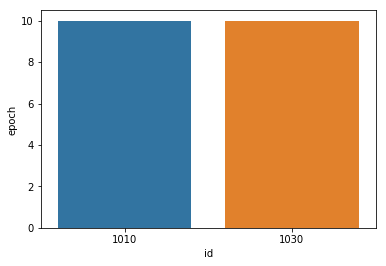

In [250]:
ax = sns.barplot(x="id", y="epoch", data=df_results[df_results['class']=='all_macro'])

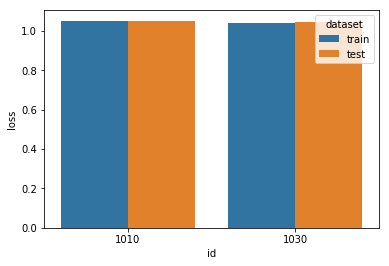

In [251]:
ax = sns.barplot(x="id", y="loss", hue="dataset", data=df_results[df_results['class']=='all_macro'])

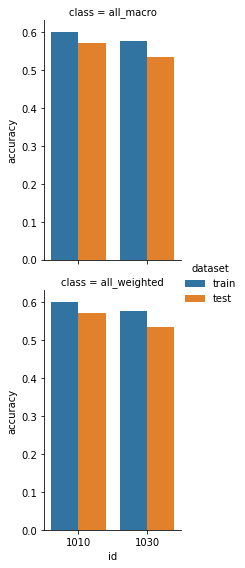

In [252]:
g = sns.catplot(x="id", y="accuracy", 
                hue="dataset", col="class",
                data=df_results[df_results['class'].isin(['all_macro','all_weighted'])], kind="bar",
                height=4, aspect=.7, col_wrap=1);

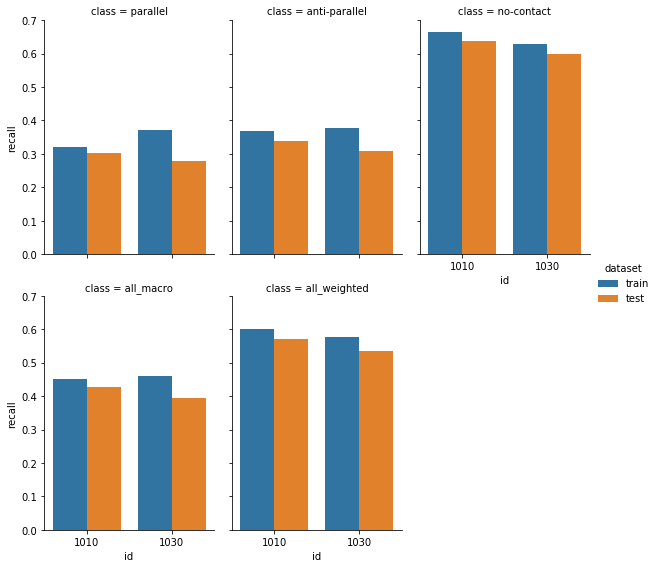

In [253]:
g = sns.catplot(x="id", y="recall", 
                hue="dataset", col="class",
                data=df_results, kind="bar",
                height=4, aspect=.7, col_wrap=3);

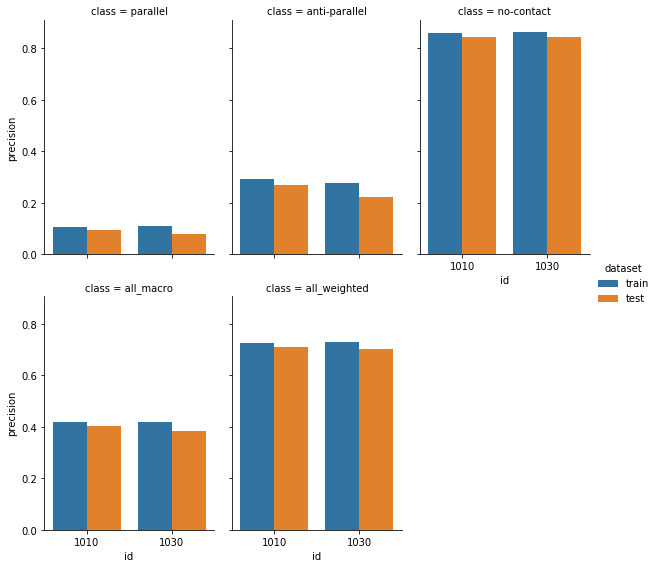

In [254]:
g = sns.catplot(x="id", y="precision", 
                hue="dataset", col="class",
                data=df_results, kind="bar",
                height=4, aspect=.7, col_wrap=3);